# Procesamiento de Imágenes
## Trabajo Practico 5 - Segmentación de Imágenes

In [1]:
import cv2
from PIL import Image
import os   
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage.data import human_mitosis

### 3. (*) Umbralización hı́brida (combinación de Otsu + morfologı́a). ¿Cómo mejorar la segmentación de objetos con ruido o regiones conectadas? Práctica sugerida: Aplicar Otsu, luego refinar con cv2.morphologyEx() (apertura o cierre).

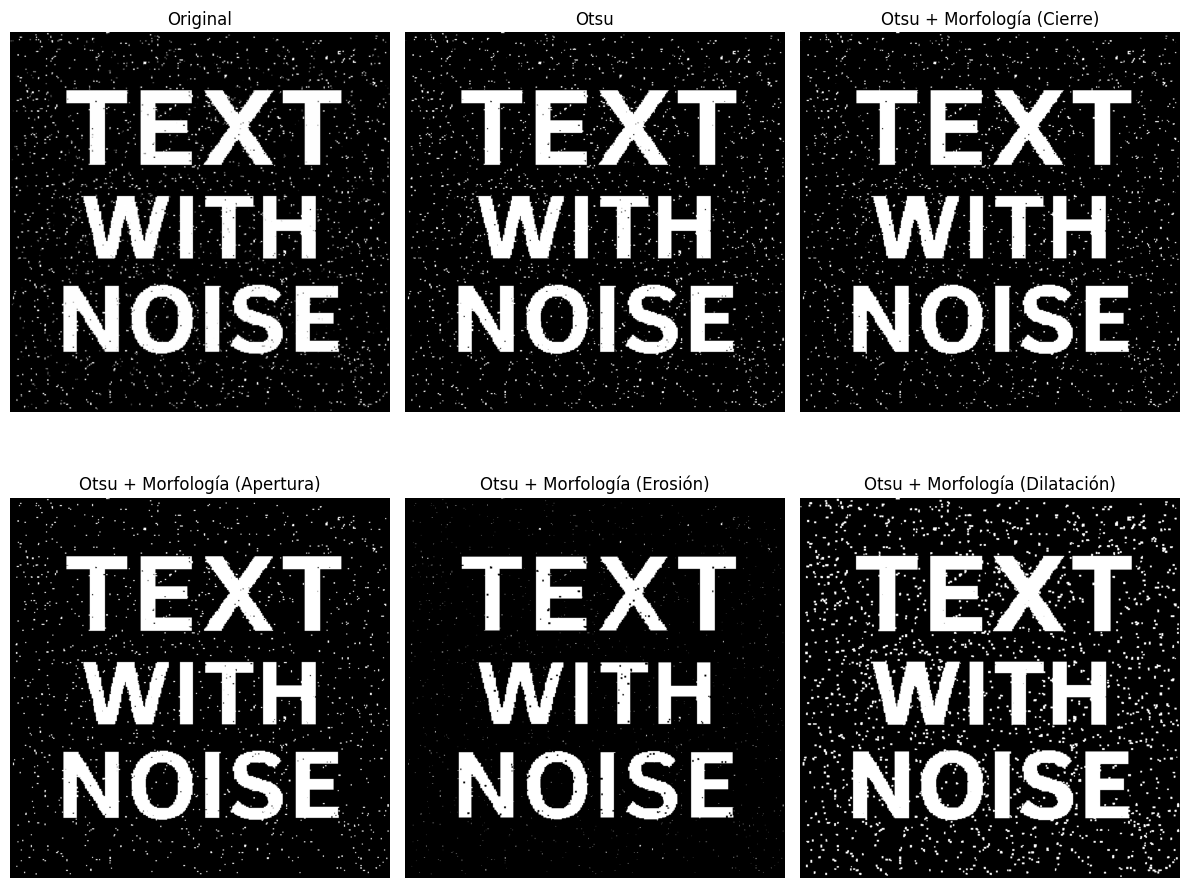

In [2]:
#render = cv2.imread('./img/render0036.png',cv2.IMREAD_GRAYSCALE)

render =cv2.imread('./img/bin2.png',cv2.IMREAD_GRAYSCALE)

# Apply Otsu
_, otsu_thresh = cv2.threshold(render, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Refine with Morphology
kernel = np.ones((3, 3), np.uint8)
refined_otsu_close = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel) 
refined_otsu_open = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel) 
refined_otsu_erode = cv2.morphologyEx(otsu_thresh, cv2.MORPH_ERODE, kernel)
refined_otsu_dilate = cv2.morphologyEx(otsu_thresh, cv2.MORPH_DILATE, kernel)

plt.figure(figsize=(12, 10))
plt.subplot(231), plt.imshow(render, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(232), plt.imshow(otsu_thresh, cmap='gray'), plt.title('Otsu'), plt.axis('off')
plt.subplot(233), plt.imshow(refined_otsu_close, cmap='gray'), plt.title('Otsu + Morfología (Cierre)'), plt.axis('off')

plt.subplot(234), plt.imshow(refined_otsu_open, cmap='gray'), plt.title('Otsu + Morfología (Apertura)'), plt.axis('off')
plt.subplot(235), plt.imshow(refined_otsu_erode, cmap='gray'), plt.title('Otsu + Morfología (Erosión)'), plt.axis('off')
plt.subplot(236), plt.imshow(refined_otsu_dilate, cmap='gray'), plt.title('Otsu + Morfología (Dilatación)'), plt.axis('off')
plt.tight_layout()
plt.show()


### 4. (*) Segmentación por detección de bordes. ¿Cómo se puede usar la información de bordes para segmentar una imagen? Práctica sugerida: Detectar bordes con cv2.Canny() o skimage.filters.sobel, luego aplicar umbral y cerrar regiones con morfologı́a.

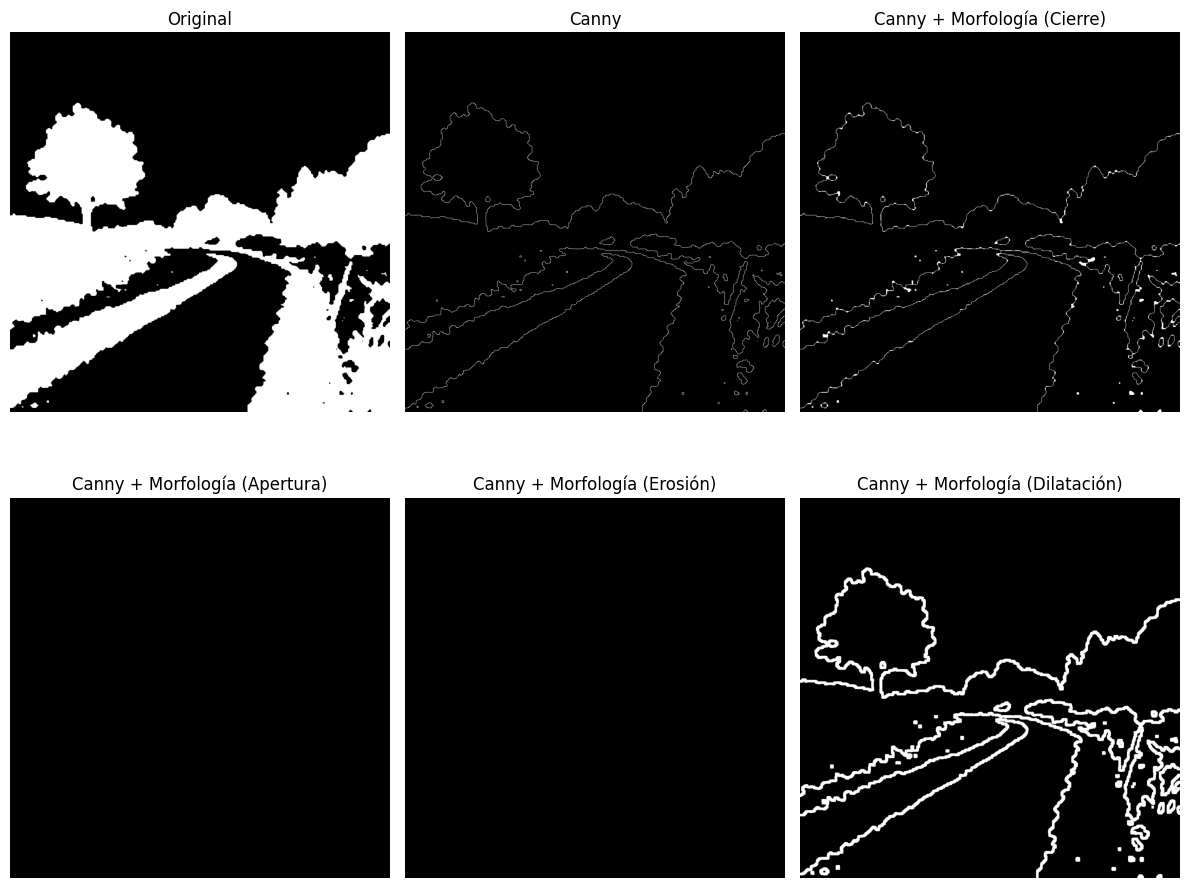

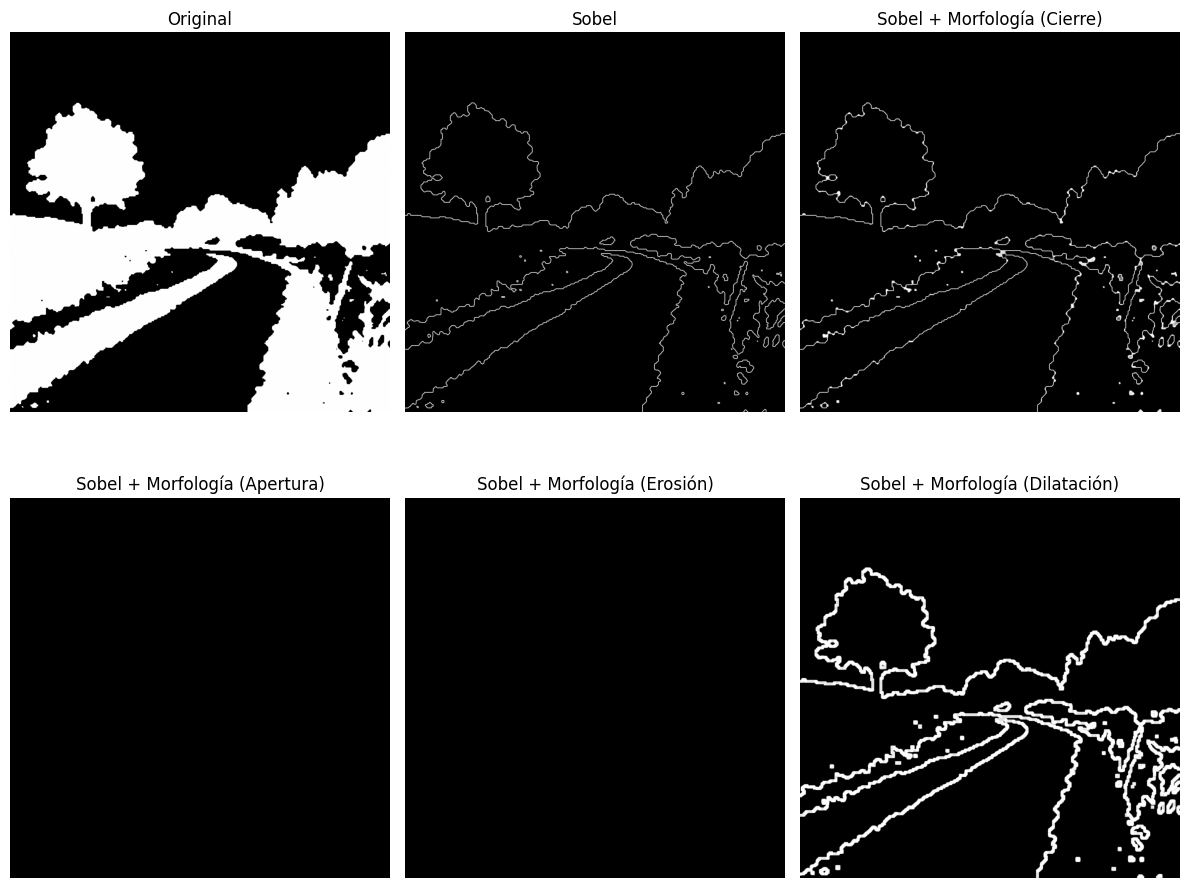

In [3]:
# Load render image

render = cv2.imread('./img/bin3.png',cv2.IMREAD_GRAYSCALE)

# Detection with Canny
edges_canny = cv2.Canny(render, 500, 150)

# Detection with Sobel
edges_sobel = filters.sobel(render)
edges_sobel = (edges_sobel * 255).astype(np.uint8)

# Close break edges with Morphology
kernel = np.ones((7, 7), np.uint8)
refined_canny_close = cv2.morphologyEx(edges_canny, cv2.MORPH_CLOSE, kernel)
refined_canny_open = cv2.morphologyEx(edges_canny, cv2.MORPH_OPEN, kernel)
refined_canny_erode = cv2.morphologyEx(edges_canny, cv2.MORPH_ERODE, kernel)
refined_canny_dilate = cv2.morphologyEx(edges_canny, cv2.MORPH_DILATE, kernel)
refined_sobel_close = cv2.morphologyEx(edges_sobel, cv2.MORPH_CLOSE, kernel)
refined_sobel_open = cv2.morphologyEx(edges_sobel, cv2.MORPH_OPEN, kernel)
refined_sobel_erode = cv2.morphologyEx(edges_sobel, cv2.MORPH_ERODE, kernel)
refined_sobel_dilate = cv2.morphologyEx(edges_sobel, cv2.MORPH_DILATE, kernel)

plt.figure(figsize=(12, 10))
plt.subplot(231), plt.imshow(render, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(232), plt.imshow(edges_canny, cmap='gray'), plt.title('Canny'), plt.axis('off')
plt.subplot(233), plt.imshow(refined_canny_close, cmap='gray'), plt.title('Canny + Morfología (Cierre)'), plt.axis('off')
plt.subplot(234), plt.imshow(refined_canny_open, cmap='gray'), plt.title('Canny + Morfología (Apertura)'), plt.axis('off')
plt.subplot(235), plt.imshow(refined_canny_erode, cmap='gray'), plt.title('Canny + Morfología (Erosión)'), plt.axis('off')
plt.subplot(236), plt.imshow(refined_canny_dilate, cmap='gray'), plt.title('Canny + Morfología (Dilatación)'), plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
plt.subplot(231), plt.imshow(render, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(232), plt.imshow(edges_sobel, cmap='gray'), plt.title('Sobel'), plt.axis('off')
plt.subplot(233), plt.imshow(refined_sobel_close, cmap='gray'), plt.title('Sobel + Morfología (Cierre)'), plt.axis('off')
plt.subplot(234), plt.imshow(refined_sobel_open, cmap='gray'), plt.title('Sobel + Morfología (Apertura)'), plt.axis('off')
plt.subplot(235), plt.imshow(refined_sobel_erode, cmap='gray'), plt.title('Sobel + Morfología (Erosión)'), plt.axis('off')
plt.subplot(236), plt.imshow(refined_sobel_dilate, cmap='gray'), plt.title('Sobel + Morfología (Dilatación)'), plt.axis('off')
plt.tight_layout()
plt.show()